In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import linear_model,  tree, ensemble, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

import warnings
warnings.filterwarnings("ignore")

Загрузим данные и проверим их на наличие пропусков

In [2]:
data = pd.read_csv('_train_sem09__1_.zip')
data.head(3)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0


In [3]:
(data.isna().sum()>0).sum()

0

In [4]:
Смотрим насколько наши данные сбалансированы.

SyntaxError: invalid syntax (4293513285.py, line 1)

<AxesSubplot:ylabel='Activity'>

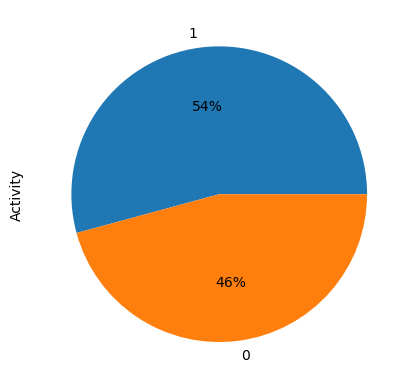

In [5]:
data.Activity.value_counts(True).plot.pie(autopct='%1.0f%%')

Данные можно считать сбалансированными, но мы всё-таки проведём стратификацию.

In [62]:
X = data.loc[:, data.columns!='Activity']
y = data['Activity']

In [63]:
splits = train_test_split(X, y, stratify=data.Activity, random_state = 1, test_size = 0.2)
X_train, X_test, y_train, y_test=splits
list(split.shape for split in splits)

[(3000, 1776), (751, 1776), (3000,), (751,)]

### Логистическая регрессия

In [64]:
# Создаем и обучаем логистическую регрессию без подбора гиперпараметров
logr = linear_model.LogisticRegression(random_state=42, max_iter=50)
logr.fit(X_train, y_train)
y_test_pred = logr.predict(X_test)
print('f1_score на тесте: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тесте: 0.79


#### GridSearchCV

In [65]:
param_grid = [
              {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}]

grid_search_log = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, cv=5, n_jobs = -1)  
%time grid_search_log.fit(X_train, y_train) 

Wall time: 1min 46s


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=50, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'penalty': ['l2', 'none'],
                          'solver': ['lbfgs', 'sag']},
                         {'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}])

In [66]:
y_test_pred = grid_search_log.predict(X_test)

In [67]:
print('f1_score на тесте: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Оптимальные значения гиперпараметров: {}".format(grid_search_log.best_params_))

f1_score на тесте: 0.79
Оптимальные значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


#### Random_search

In [68]:
param_grid = {'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search_log = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_log.fit(X_train, y_train) 
y_test_pred = random_search_log.predict(X_test)
print('f1_score на тесте: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Оптимальные значения гиперпараметров: {}".format(random_search_log.best_params_))

Wall time: 1min 5s
f1_score на тесте: 0.79
Оптимальные значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}


#### Hyperopt

In [69]:
space={'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver' : hp.choice('solver', ['saga', 'sag', 'lbfgs']),
       'C': hp.choice('C', {0.01,0.02,0.03,0.04,0.05,0.07,0.09,1})}  

random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'penalty': params['penalty'], 
              'solver': params['solver'],
             'C': params['C']}
    model = linear_model.LogisticRegression(**params, random_state=42, max_iter=50)
    # Проводим кросс-валидацию на 5 фолдах.
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # меняем знак метрики
    return -score

# Перебираем гиперпараметры
trials = Trials()

best=fmin(hyperopt_rf,
          space=space,
          # algo=tpe.suggest,
          max_evals=50,
          trials=trials,
          rstate=np.random.default_rng(random_state))
print("Оптимальные значения гиперпараметров {}".format(best))

TPE is being used as the default algorithm.


100%|██████████| 50/50 [02:39<00:00,  3.19s/trial, best loss: -0.7847018881272774]
Оптимальные значения гиперпараметров {'C': 4, 'penalty': 0, 'solver': 0}


In [70]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 280, 'max_depth': 40, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.81


In [71]:
# Вычислим оценку f1 на тесте


model = linear_model.LogisticRegression(penalty="l2", solver="saga", C=0.05, random_state=42, max_iter=50)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.84
f1_score на тестовом наборе: 0.80


#### Optuna

In [72]:
def optuna_lr(trial):
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
    C = trial.suggest_float('C', 0.01, 1)
    model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=42,
                                          max_iter=50)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [73]:
%%time
# cоздаем объект исследования и запрашиваем максимизацию метрики
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# Подбираем оптимальный набор значений гиперпараметров
study.optimize(optuna_lr, n_trials=50)

[I 2022-10-15 05:57:57,512] A new study created in memory with name: LogisticRegression
[I 2022-10-15 05:57:59,033] Trial 0 finished with value: 0.77352434990562 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.42974363822756145}. Best is trial 0 with value: 0.77352434990562.
[I 2022-10-15 05:58:00,656] Trial 1 finished with value: 0.7525843675694686 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.4210359138411458}. Best is trial 0 with value: 0.77352434990562.
[I 2022-10-15 05:58:02,408] Trial 2 finished with value: 0.7525843675694686 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.7227328511529179}. Best is trial 0 with value: 0.77352434990562.
[I 2022-10-15 05:58:05,765] Trial 3 finished with value: 0.7821820948013027 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.14190220742225748}. Best is trial 3 with value: 0.7821820948013027.
[I 2022-10-15 05:58:07,576] Trial 4 finished with value: 0.7705528742753971 and parameters: {'penalty': 

Wall time: 2min 24s


In [74]:
# смотрим результаты на обучающем сете
print("Оптимальные значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем выборке: {:.2f}".format(study.best_value))

Оптимальные значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.021613256729205478}
f1_score на обучающем выборке: 0.78


In [75]:
# считаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


Использование Optuna не улучшило предсказательную силу модели полученной с помощью Hyperopt

### Random Forest 

Теперь повторим всё ранее сделанное с моделью построенной методом "случайного леса" вместо логистической регрессии.

In [76]:
#Создаём модель с использованием "случайного леса" со стандартными значениями гиперпараметров.

rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


Мы видим резхкое улучшение метрики как для обучающей, так и для тестовой группы.

#### GridSearchCV

In [77]:
param_grid = {'n_estimators': list(range(100, 300, 30)),
              'min_samples_leaf': list(np.linspace(2, 10, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))}
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1)  

In [78]:
%%time
grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Оптимальные значения гиперпараметров: {}".format(grid_search_forest.best_params_))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82
Оптимальные значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 2, 'n_estimators': 280}
Wall time: 1min 40s


Целевая метрика выросла до 0.82

#### Randomized SearchCV

In [79]:
param_grid = {'n_estimators': list(range(100, 300, 30)),
              'min_samples_leaf': list(np.linspace(2, 10, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1) 

In [80]:
%%time 
random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 280, 'min_samples_leaf': 2, 'max_depth': 28}
Wall time: 2min 35s


Значение метрика F1 улучшена до 0.83. 

#### Hyperopt

In [81]:
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 30),
       'max_depth' : hp.quniform('max_depth', 20, 40, 10),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)}

random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])              }
  
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [ ]:
%%time
trials = Trials()

best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=20,
          trials=trials,
          rstate=np.random.default_rng(random_state))
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Целевая метрика не изменила своего значения. 

#### Optuna

In [ ]:
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 310, 30)
    max_depth = trial.suggest_int('max_depth', 20, 40, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель с помощью кросс-валидации
  # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [ ]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=50)

In [ ]:
# Оценка по обучающей выборке
print("Оптимальные значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

In [ ]:
# оценка по тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тесте: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Целевая метрика не улучшилась. Максимальное значение метрики F1 (0.83) на тестовой выборке наблюдается для моделей случайного леса,
построенных на гиперпараметрах полученных с помощью случайного поиска или Hyperopt-а. При этом, более оперативно сработал Hyperopt (на 64% быстрее).

In [ ]:
100-round(51/140*100, 2)